# Notebook 4
## Anthopological processing

Encoding and merging the anthropological data; this includes:
- Marine Protected Area
- Population
- Coal
- Night Lights
- Distance to urban 
- Land coverage


In [60]:
# Importing packages

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from osgeo import gdal
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))
import rasterio


from rasterio.plot import show
from pyproj import Proj, transform
import data_processing_helper as dp
import practical_functions as pf
import glob

plt.style.use('ggplot') # use ggplot style

In [61]:
df_env = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")
# Make geodataframe
dp.geo_loads(df_env)

df_env = pf.make_geo_frame(df_env)
df_env['surveydate'] = pd.to_datetime(df_env['surveydate'], format='%Y-%m')
df_env["year"] = df_env["surveydate"].dt.year
df_env['surveydate'] = df_env['surveydate'].dt.strftime('%Y-%m')

### Shape files

In [62]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

## Urban Shapefiles
Take the Urban shape file with the locations of the urban centers around the world

In [63]:
urban = gpd.read_file('../Data/Anthropological_data/Urban/grump-v1-urban-ext-polygons-rev02-shp/global_urban_extent_polygons_v1.01.shp')
Urban_survey = urban[(urban["ISO3"] == "AUS") | (urban["ISO3"] == "IDN") | (urban["ISO3"] == "TLS")| (urban["ISO3"] == "SLB")]

# Take the centroid of the polygon geometry
# (lon,lat)
Urban_survey["geometry"] = Urban_survey["geometry"].centroid

In [64]:
# swap to (lat, lon) for the nearest_neighbor function
dp.swap_coordinates(Urban_survey)

,OBJECTID,URBID,LIGHTDCW,ES90POP,ES95POP,ES00POP,PCOUNT,SCHNM,NAME,SQKM_FINAL,ISO3,ISOURBID,REMOVED_PO,ADDED_POIN,YEAR_V1_01,POP_V1_01,Unsdcode,Countryeng,Continent,geometry
116,117,146,1,6.013470e-154,6.013470e-154,6.013470e-154,0,None,None,49.9526,AUS,AUS146,None,None,0.0,0.0,36,Australia,Oceania,POINT (-40.849 145.144)
121,122,151,1,6.013470e-154,6.013470e-154,6.013470e-154,0,None,None,23.7339,AUS,AUS151,None,None,0.0,0.0,36,Australia,Oceania,POINT (-41.000 145.724)
123,124,153,1,1.692200e+04,1.789400e+04,1.892200e+04,1,BURNIE,Burnie,83.2889,AUS,AUS153,None,None,0.0,0.0,36,Australia,Oceania,POINT (-41.077 145.898)
130,131,160,1,6.013470e-154,6.013470e-154,6.013470e-154,0,None,None,157.0060,AUS,AUS160,None,None,0.0,0.0,36,Australia,Oceania,POINT (-41.145 146.900)
131,132,161,1,6.013470e-154,6.013470e-154,6.013470e-154,0,None,None,139.7280,AUS,AUS161,None,None,0.0,0.0,36,Australia,Oceania,POINT (-41.151 144.764)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67684,67685,90066,4,3.150000e+04,3.949200e+04,4.988000e+04,1,SUMBERPUCUNG,Sumber?Pucung,41.5487,IDN,IDN90066,None,None,0.0,0.0,360,Indonesia,Asia,POINT (-8.150 112.467)
67706,67707,90067,4,3.210000e+04,4.024400e+04,5.083100e+04,1,TANGGUL,Tanggul,42.1462,IDN,IDN90067,None,None,0.0,0.0,360,Indonesia,Asia,POINT (-8.167 113.433)
67726,67727,90068,4,2.380000e+04,2.983800e+04,3.768700e+04,1,TEMPEH,Tempeh,33.6048,IDN,IDN90068,None,None,0.0,0.0,360,Indonesia,Asia,POINT (-8.200 113.167)
67746,67747,90069,4,2.630000e+04,3.297200e+04,4.164600e+04,1,SINGOJURUH,Singojuruh,36.2440,IDN,IDN90069,None,None,0.0,0.0,360,Indonesia,Asia,POINT (-8.317 114.233)


In [65]:
# Find closest urban center to the survey points in meters
df_env_dist = dp.nearest_neighbor(df_env, Urban_survey)

In [66]:
df_env["distance_urban"] = df_env_dist["distance"]

### Marine Protected Areas

In [67]:
marine_prot_points = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-points.shp")
marine_prot_poly = gpd.read_file("../Data/Anthropological_data/Marine__protection/WDPA_WDOECM_Apr2021_Public_marine_shp-polygons.shp")

In [68]:
marine_prot_points = marine_prot_points[(marine_prot_points["ISO3"] == "AUS") | (marine_prot_points["ISO3"] == "IDN") | (marine_prot_points["ISO3"] == "TLS")| (marine_prot_points["ISO3"] == "SLB")]
marine_prot_poly = marine_prot_poly[(marine_prot_poly["ISO3"] == "AUS") | (marine_prot_poly["ISO3"] == "IDN") | (marine_prot_poly["ISO3"] == "TLS")| (marine_prot_poly["ISO3"] == "SLB")]
# let me add a centroid column
marine_prot_poly["centroid"] = marine_prot_poly.centroid

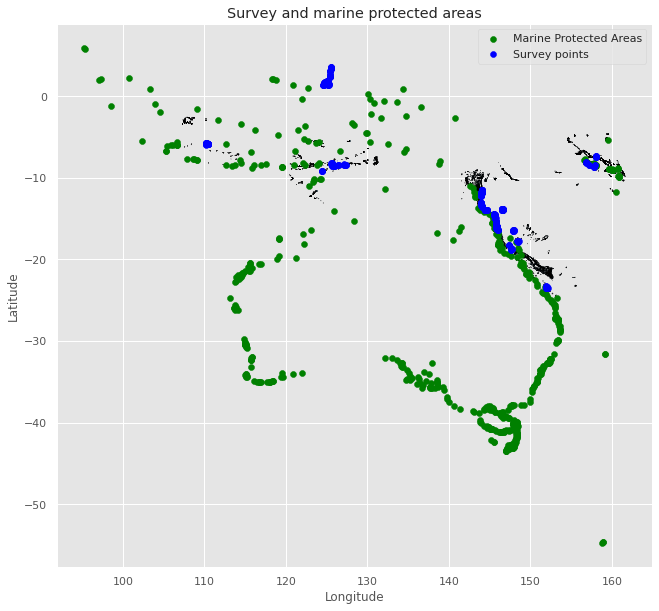

In [69]:
ax = gdf_PAC.plot(edgecolor = "black", figsize  = (20,10), label = "Shapefile");
marine_prot_poly["centroid"].plot(ax = ax, color = "Green")
marine_prot_points.plot(ax = ax, label = "Marine Protected Areas", color = "Green")
df_env_lonlat = dp.swap_coordinates(df_env)
df_env_lonlat.plot(ax = ax, label = "Survey points", color = "blue")
plt.legend();
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Survey and marine protected areas");


In [70]:
marine_prot_poly.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)
marine_prot = pd.concat([marine_prot_poly,marine_prot_points ],ignore_index = True)

In [71]:
# turn multipoint into point
def mult_to_point(df, first_index):
    for ind in range(first_index, len(df)):
        df["geometry"][ind] = Point(df["geometry"][ind][0].x,df["geometry"][ind][0].y)
        
    return df

In [72]:
marine_prot = mult_to_point(marine_prot, 546)

In [73]:
# Drop columns which are not of interst
marine_prot.drop(columns = ['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'MARINE',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'OWN_TYPE',
       'MANG_AUTH', 'MANG_PLAN', 'VERIF', 'METADATAID', 'SUB_LOC',
       'PARENT_ISO', 'ISO3', 'SUPP_INFO', 'CONS_OBJ', 'polygon'],inplace = True)

In [74]:
# Closest point from marine protected area
dp.swap_coordinates(marine_prot)
marine_prot["geometry"]

0      POINT (-33.316 151.527)
1      POINT (-33.520 151.388)
2      POINT (-18.617 146.495)
3      POINT (-14.670 145.459)
4      POINT (-32.298 133.670)
                ...           
575     POINT (-8.447 157.994)
576     POINT (-5.974 106.693)
577      POINT (-1.170 98.580)
578     POINT (-6.850 115.730)
579     POINT (-5.859 132.571)
Name: geometry, Length: 580, dtype: geometry

In [75]:
df_marine_pro = dp.nearest_neighbor(df_env, marine_prot)

In [76]:
df_env["dist_marine_protection"] = df_marine_pro["distance"]

### Population 

In [77]:
pop = pd.read_csv("../Data/Anthropological_data/Population_pred/Population-EstimatesData.csv")
pop.drop(columns = ["Unnamed: 95","Indicator Code"], inplace = True)
pop = pop[(pop["Country Code"] == "AUS") | (pop["Country Code"] == "IDN") | (pop["Country Code"] == "TLS")| (pop["Country Code"] == "SLB")]
pop = pop[pop['Indicator Name'].str.contains("Population growth|Population, total")]

In [78]:
total_pop = pop[pop["Indicator Name"] == "Population, total"].dropna(axis = 1)
total_growth = pop[pop["Indicator Name"] == "Population growth (annual %)"].dropna(axis = 1)

Text(0.5, 1.0, 'Population growth')

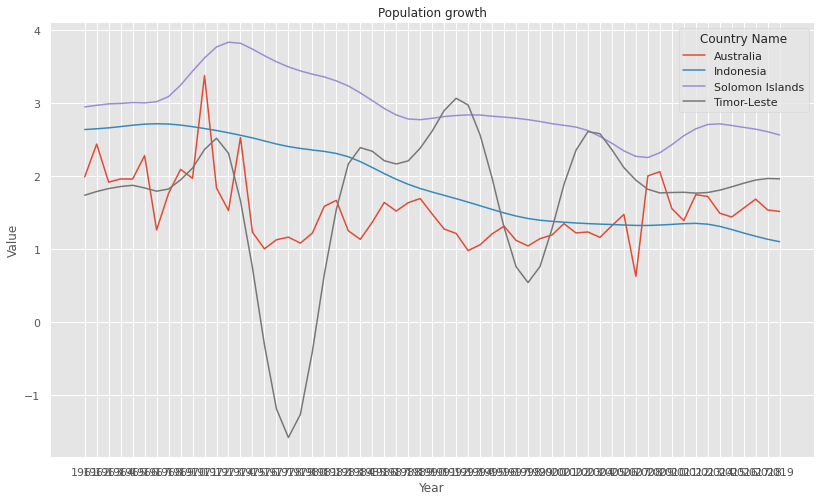

In [79]:
total_growth_melt = total_growth.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_growth_melt["Year"], y = total_growth_melt["Value"], hue = total_growth_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population growth")

Text(0.5, 1.0, 'Population total')

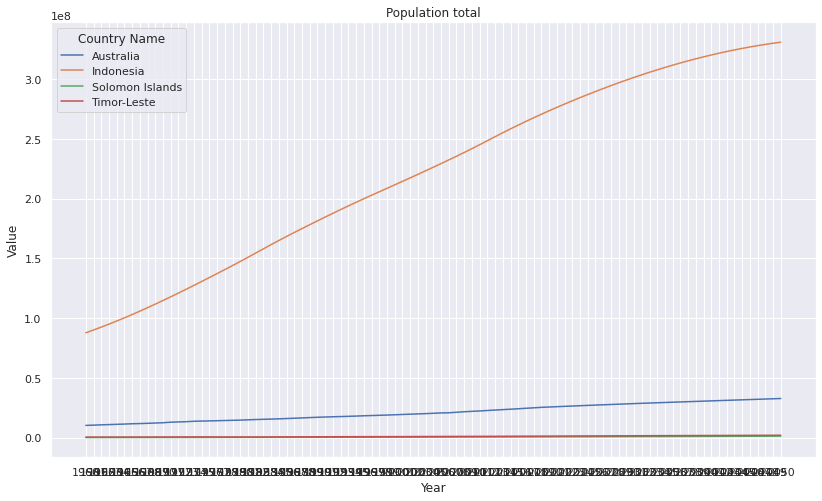

In [80]:
total_pop_melt = total_pop.melt(id_vars=["Country Name", "Country Code", "Indicator Name"], 
        var_name="Year", 
        value_name="Value")
sns.lineplot(x = total_pop_melt["Year"], y = total_pop_melt["Value"], hue = total_pop_melt["Country Name"])
sns.set(rc={'figure.figsize':(13.7,8)})
plt.title("Population total")

In [81]:
total_pop_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)
total_growth_melt.rename(columns = ({"Country Code": "country", "Year":"year"}), inplace = True)

In [82]:
total_pop_melt["year"] = total_pop_melt["year"].astype(int)
total_growth_melt["year"] = total_growth_melt["year"].astype(int)

In [83]:
df_env = pd.merge(df_env,total_pop_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population"}))

In [84]:
df_env = pd.merge(df_env,total_growth_melt,on = ["country", "year"]).drop(columns = ["Country Name", "Indicator Name"]).rename(columns = ({"Value":"Population_growth"}))

### Land coverage for Australia and utilities 

In [85]:
gLand = gpd.read_file('../Data/Anthropological_data/Land_commodities/CLUM_Commodities_2020.shp')

In [86]:
gLand["centroid"] = gLand["geometry"].centroid

In [87]:
gLand.rename(columns = {"geometry":"polygon", "centroid":"geometry"}, inplace = True)

In [88]:
dp.swap_coordinates(gLand)
gLand["geometry"]

0         POINT (-35.205 148.989)
1         POINT (-35.346 149.151)
2         POINT (-35.313 149.179)
3         POINT (-35.230 149.193)
4         POINT (-35.225 149.195)
                   ...           
146873    POINT (-41.067 147.884)
146874    POINT (-41.075 147.881)
146875    POINT (-40.987 147.312)
146876    POINT (-41.492 146.577)
146877    POINT (-41.149 145.817)
Name: geometry, Length: 146878, dtype: geometry

In [89]:
closest_agr = dp.nearest_neighbor(df_env, gLand)

In [31]:
closest_agr.rename(columns = {"distance":"dist_agr", "Commod_dsc":"agr_type"},inplace = True)

In [32]:
df_env = pd.concat([df_env,closest_agr[["agr_type","Broad_type", "dist_agr"]]], join = "outer", axis = 1)

In [33]:
col_agr = ["agr_type","Broad_type", "dist_agr"]
df_env.loc[df_env['country'] != "AUS", col_agr] = np.nan

### Coaling areas

In [34]:
Coal = rasterio.open("../Data/Anthropological_data/Coaling/global_miningarea_v1_30arcminute.tif")

In [35]:
coal_arr = Coal.read(1)

In [36]:
Coal.crs

CRS.from_epsg(4326)

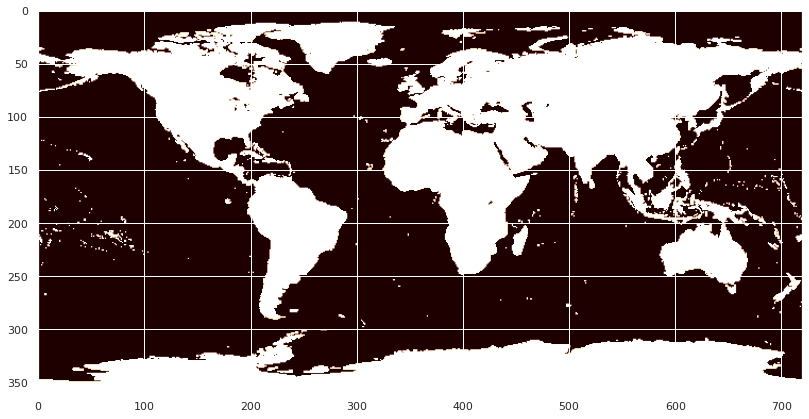

In [37]:
from matplotlib import pyplot
pyplot.imshow(coal_arr, cmap='pink')

In [38]:

coords = np.where(coal_arr > 0)

out_trans = Coal.transform
coal_values = coal_arr[coords]
# keep indices of coordinates with one
lon_ind = list(coords[0])
lat_ind = list(coords[1])
# Find the (x,y) coordinates in the raster file
coordinate = rasterio.transform.xy(out_trans,lon_ind, lat_ind)
lon_lat_coords = np.dstack((coordinate[0],coordinate[1]))

In [39]:
lon_lat_coords = lon_lat_coords[0, :, :]

In [40]:
# Make a dataframe with the coordinates
df_coal = pd.DataFrame(lon_lat_coords[:,0],lon_lat_coords[:,1]).reset_index()

In [41]:
df_coal.rename(columns = {"index":"lat", 0:"lon"}, inplace = True)

In [42]:

# Make a geodataframe with the coordinates
gdf_coal = gpd.GeoDataFrame(
    df_coal, geometry=gpd.points_from_xy(df_coal.lat, df_coal.lon))
gdf_coal["mine_area_per_call"] = coal_values

In [43]:
df_near = dp.nearest_neighbor(df_env, gdf_coal)
df_env["mine_area_per_cell"] = df_near["mine_area_per_call"]
df_env["distance_to_mine_area"] = df_near["distance"]

# Nightlights 
Yearly - 2012/2018
- avg_rad within 15 km 

In [44]:
list_dates = ["2012", "2013", "2014", "2015", "2016", "2017", "2018"]

In [45]:
ds=gdal.Open('../Data/Anthropological_data/NightLight/VIIRS_15km_2013.tif')
prj=ds.GetProjection()
print(prj)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [46]:
def nighlight(df_env, list_dates):
    
    for date in list_dates:
        nightlights = rasterio.open(format(f"../Data/Anthropological_data/NightLight/VIIRS_15km_{date}.tif"))
        arr = nightlights.read(1)
        coords = np.where((~np.isnan(arr)) & (arr > 0))
        out_trans = nightlights.transform
        night_values = arr[coords]
        
        # keep indices of coordinates with no nans
        lon_ind = list(coords[0])
        lat_ind = list(coords[1])
        # Find the (x,y) coordinates in the raster file
        coordinate = rasterio.transform.xy(out_trans,lon_ind, lat_ind)
        lon_lat_coords = np.dstack((coordinate[0],coordinate[1]))
        lon_lat_coords = lon_lat_coords[0, :, :]
        # Make a dataframe with the coordinates
        df_night = pd.DataFrame(lon_lat_coords[:,0],lon_lat_coords[:,1]).reset_index()
        df_night.rename(columns = {"index":"lat", 0:"lon"}, inplace = True)

# Make a geodataframe with the coordinates
        gdf_night = gpd.GeoDataFrame(
            df_night, geometry=gpd.points_from_xy(df_night.lat, df_night.lon))


        gdf_night["nightlight"] = night_values
        df_near = dp.nearest_neighbor(df_env, gdf_night)
        df_env[format(f"nigh_avg_{date}")] = df_near["nightlight"]
        df_env[format(f"nigh_avg_distance_{date}")] = df_near["distance"]
        
        
        
        
    

In [47]:
nighlight(df_env, list_dates)

In [48]:
filter_col_distance = [col for col in df_env if col.startswith('nigh_avg_distance')]

### Fishing

In [ ]:
import pyproj as proj
"""
    Careful this piece of code is computationally expensive, my computer could not handle it and I had to splot the data. 
    Splitted the data by two for year 2016 [2016a and 2016b]and concatenate
    PS: I was not able to run the year 2018 due to the heavy file.
"""

def fishing_dist(df_env, list_dates, min_dist = 50000):
    for date in list_dates:
        print(date)
        path = format(f"../Data/Anthropological_data/Fishing/fleet-daily-csvs-100-v2-{date}")
        all_files = glob.glob(path + "/*.csv")
        li = []

        for filename in all_files:
            df = pd.read_csv(filename, index_col=None, header=0)

            df = df[(((df['cell_ll_lon'].between(110,160)) & (df['cell_ll_lat'].between(-24,4)) & (df['fishing_hours'] != 0)))]

            li.append(df)
        frame = pd.concat(li, axis=0, ignore_index=True)
        frame.rename(columns = {"cell_ll_lat":"lat", "cell_ll_lon":"lon"},inplace = True)
        gframe = gpd.GeoDataFrame(
        frame, geometry=gpd.points_from_xy(frame.lat, frame.lon), crs = "WGS84")
        

        # setup your projections
        crs_wgs = proj.Proj(init='epsg:4326') 
        crs_bng = proj.Proj(init='epsg:3112') # use a locally appropriate projected CRS

        # then cast your geographic coordinate pair to the projected system
        x_fish, y_fish = proj.transform(crs_wgs, crs_bng, frame["lon"][:].to_list(), frame["lat"][:].to_list())
        
        print(format(f"year {date} transform done"))
        # First round 
        
        
        x_env, y_env = proj.transform(crs_wgs, crs_bng, df_env["lon"][:].to_list(), df_env["lat"][:].to_list())
        df_env["x"] = x_env
        df_env["y"] = y_env
        genv = df_env.copy()
        genv = gpd.GeoDataFrame(
                    genv, geometry=gpd.points_from_xy(genv.x, genv.y))
            
        frame["x"] = x_fish
        frame["y"] = y_fish
        
        gxframe = gpd.GeoDataFrame(
    frame, geometry=gpd.points_from_xy(frame.x, frame.y))
        print(format(f"year {date} made geoDataFrame"))
        
        df_distance_fishing = genv.geometry.apply(lambda g: gxframe.distance(g))
        print(format(f"year {date} computed distance"))
        dmin = min_dist # 100 km#(df_fi).min().std()
        
        
        # Fill weight = 1 if within 50km else 0
        df_distance_fishing[~df_distance_fishing[df_distance_fishing < dmin].isnull()] = 1
        df_distance_fishing[df_distance_fishing != 1] = 0
        print(format(f"year {date} finished assigning"))
        
        fish_hours = gxframe["hours"]
        hours_ = df_distance_fishing *fish_hours
        df_env[format(f"fish_hours_{date}")] = hours_.sum(axis = 1)
        
    
    
    
    

In [52]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]

# 50 km arund survey point I say yes, else no
min_dist = 50000
list_dates_ = ["2012", "2014", "2016a", "2016b", "2017"]
# Could not run 2018 due to heavy file 
#list_dates_ = ["2012", "2014", "2016", "2017", "2018"]

In [53]:
fishing_dist(df_env, list_dates_)

2012
year 2012 transform done
year 2012 made geoDataFrame
year 2012 computed distance
year 2012 finished assigning
2014
year 2014 transform done
year 2014 made geoDataFrame
year 2014 computed distance
year 2014 finished assigning
2016a
year 2016a transform done
year 2016a made geoDataFrame
year 2016a computed distance
year 2016a finished assigning
2016b
year 2016b transform done
year 2016b made geoDataFrame
year 2016b computed distance


KeyboardInterrupt: 

### Land Coverage
Data-set is huge, thus changing to NETCDF and merging there is better as it did not accept merging the tiff files. Did not work and using NetCDF is HUGE as well...
https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V2.0_I2.20.pdf
Labels
- 10 - Forest/tree cover
- 20 - Shrub
- 30 - Herbaous vegetation
- 40 - Cultivated and managed vegetation/agriculture
- 50 - Urban/built up
- 60 - Bare/sparse vegetation
- 70 - Snow and Ice
- 80 - Open water
- 90 - Wetland



Because of the size. I use a 5km rescaling thanks to Google Earth Engine  

In [157]:
filename = "../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5km.tif"
input_raster = gdal.Open(filename)
for epsg in ["EPSG:4326"]:
    gdal.Warp('../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5km' + epsg + '.tif', input_raster, dstSRS=epsg)

In [158]:
# Array
LC_5km = rasterio.open('../Data/Anthropological_data/Land_cover/Agriculture_cover_google_masked_5kmEPSG:4326.tif')
arr = LC_5km.read(1)

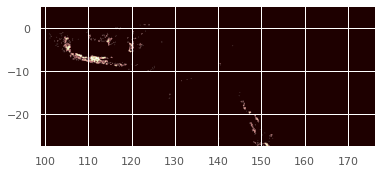

<AxesSubplot:>

In [159]:
from matplotlib import pyplot
from rasterio.plot import show
show(arr, cmap='pink',transform=LC_5km.transform)

In [ ]:
rc = np.transpose(np.nonzero(arr==1))
lonlat = [LC_5km.xy(row, col) for row, col in rc]

# Use itterator to separate lat,lon in list file
a,b = map(itemgetter(0),lonlat), map(itemgetter(1),lonlat)
lon,lat = map(list,zip(*lonlat))

In [ ]:
# Make a dataframe with the coordinates
df_LC = pd.DataFrame(lat,lon).reset_index()

df_LC.rename(columns = {"index":"lon", 0:"lat"}, inplace = True)
# Make a geodataframe with the coordinates
gdf_LC = gpd.GeoDataFrame(
    df_LC, geometry=gpd.points_from_xy(df_LC.lat, df_LC.lon))

# dataframe with closest agricultural land 
df_near = dp.nearest_neighbor(df_env, gdf_LC)

df_env["distance_agr_land"] = df_near["distance"]

df_env.to_csv("../Data/merged_30_04.csv", index = False)

In [4]:
df_merged_30 = pd.read_csv("../Data/merged_30_04.csv")

In [55]:
# Collect the extended data
df_env_extend = pd.read_csv("../Data/Environmental_data/df_env_merged_extended_5_5.csv")

In [18]:
# Keep the extended features
df_env_extend = df_env_extend[df_env_extend.columns[21:]]

In [20]:
df_merged_extended = pd.concat([df_merged_30,df_env_extend], axis = 1)

In [22]:
df_merged_extended.to_csv("../Data/merged_5_05_extended.csv", index = False)